In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib
import numpy as np
from typing import Tuple, Iterable
from datetime import datetime
import re 
from enum import IntEnum
#import seaborn as sns
from scipy.stats import ranksums
import os
import glob

In [18]:
# # experiment computer has locale set to german -_-
import locale
import contextlib
@contextlib.contextmanager
def setlocale(*args, **kw):
    saved = locale.setlocale(locale.LC_ALL)
    yield locale.setlocale(*args, **kw)
    locale.setlocale(locale.LC_ALL, saved)

PIX_PER_MM = 38.773681409813456
CAM_WIDTH = 2048
CAM_HEIGHT = 2048

def parse_filename(filename: str, loc: str = 'de_DE.utf8') -> Tuple:

    regexp = re.compile(r"""
        (?P<fish_id>\d+)_
        (?P<dpf>\d+)dpf_
        (?P<datetime>\w+).csv
        """, re.VERBOSE)

    match = regexp.fullmatch(filename)
    if match is None:
        raise RuntimeError(f'Wrong filename format, {filename}')
    
    fish_id = int(match.group('fish_id'))
    dpf = int(match.group('dpf'))
    
    with setlocale(locale.LC_ALL, loc):
        date = datetime.strptime(match.group('datetime'),'%a_%d_%b_%Y_%Hh%Mmin%Ssec')
    
    return (fish_id, dpf, date)

def get_relative_time(data):
    return data['t_local'] - data['t_local'].iloc[0]

def get_relative_index(data):
    return data.index - data.index[0]

def get_heading_angle(data):
    angle = np.arctan2(data['pc1_y'],data['pc1_x'])
    notna = ~np.isnan(angle)
    angle_unwrapped = np.zeros_like(angle) * np.nan
    angle_unwrapped[notna] = np.unwrap(angle[notna]) # TODO this is probably a bit wrong
    return angle, angle_unwrapped

def get_distance(data):
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    distance = np.sqrt(x_diff**2+y_diff**2)
    return distance * 1/PIX_PER_MM

class StimType(IntEnum):
    DARK = 0
    BRIGHT = 1
    PHOTOTAXIS = 2
    OMR = 3
    OKR = 4
    LOOMING = 5



In [19]:
#read the files, make separate dataframes by grouping the StimType, and add the parsed columns to it
#use the get_relative_time , get_relative_index, get_heading_angle, get_distance functions
#Plot the centroids
#plot the heading_angle
#calculate the speed


#TODO: before plotting, group by fish_id


DATA_FOLDER = r".\Modelling_data\Cichlids"

DATAFILES = [
    "08_09dpf_Di_27_Aug_2024_14h50min47sec.csv", 
    "09_09dpf_Di_27_Aug_2024_16h03min14sec.csv"
]


# Initialize dictionaries for specific stimulus types
target_stims = [StimType.DARK, StimType.BRIGHT, StimType.PHOTOTAXIS]
stim_dataframes = {stim: pd.DataFrame() for stim in target_stims}

for file in DATAFILES:
   fish_id, dpf, date = parse_filename(file)
   
   # Read and preprocess data
   data = pd.read_csv(os.path.join(DATA_FOLDER, file))
   data_filtered = data.groupby('image_index').first()
   data_filtered = data_filtered[1:]
   data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
   
   # Add parsed metadata to each row
   data_filtered['fish_id'] = fish_id
   data_filtered['dpf'] = dpf
   data_filtered['date'] = date
   
   # Group by specific stimulus types and concatenate
   for stim in target_stims:
       stim_data = data_filtered[data_filtered['stim_id'] == stim.value]
       stim_dataframes[stim] = pd.concat([stim_dataframes[stim], stim_data])

# Optional: Save each stimulus type DataFrame
for stim, df in stim_dataframes.items():
   if not df.empty:
       df.to_csv(f'{stim.name.lower()}_data.csv', index=False)


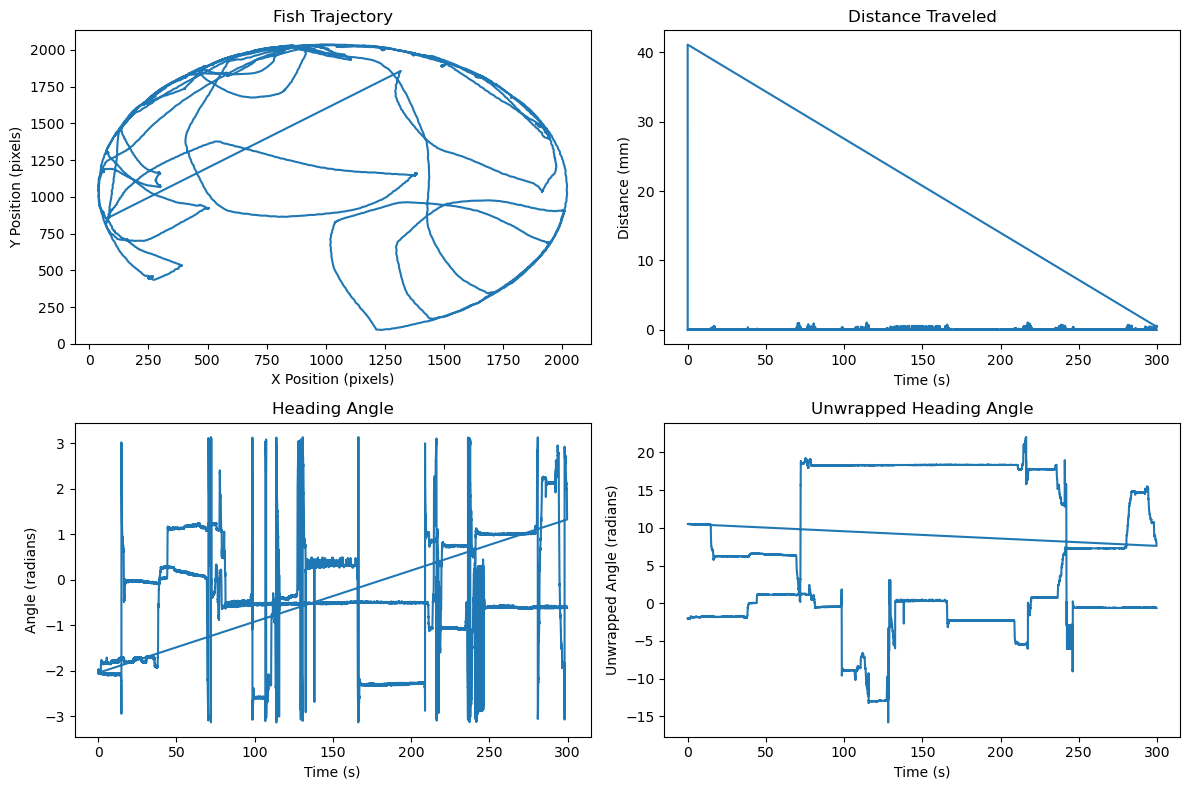

In [34]:
bright_df = pd.read_csv(r'.\bright_data.csv')
# Preprocessing
bright_df['relative_time'] = get_relative_time(bright_df)
bright_df['relative_index'] = get_relative_index(bright_df)
bright_df['distance'] = get_distance(bright_df)
bright_df['angle'], bright_df['unwrapped_angle'] = get_heading_angle(bright_df)

# Trajectory Visualization
plt.figure(figsize=(12, 8))

# Trajectory plot
plt.subplot(2, 2, 1)
plt.plot(bright_df['centroid_x'], bright_df['centroid_y'])
plt.title('Fish Trajectory')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')

# Distance over time
plt.subplot(2, 2, 2)
plt.plot(bright_df['relative_time'], bright_df['distance'])
plt.title('Distance Traveled')
plt.xlabel('Time (s)')
plt.ylabel('Distance (mm)')

# Heading angle over time
plt.subplot(2, 2, 3)
plt.plot(bright_df['relative_time'], bright_df['angle'])
plt.title('Heading Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')

# Unwrapped angle over time
plt.subplot(2, 2, 4)
plt.plot(bright_df['relative_time'], bright_df['unwrapped_angle'])
plt.title('Unwrapped Heading Angle')
plt.xlabel('Time (s)')
plt.ylabel('Unwrapped Angle (radians)')

plt.tight_layout()
plt.show()

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_8628\3795500128.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


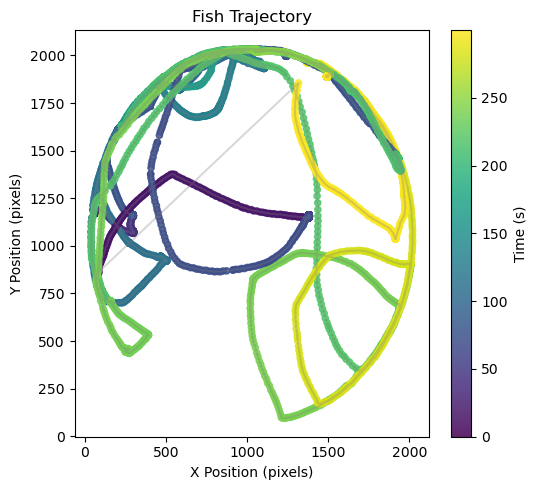

In [57]:
plt.figure(figsize=(15, 5))

# Trajectory plot with smoother time gradient
plt.subplot(1, 3, 1)
# Create a custom colormap that transitions more smoothly
custom_cmap = plt.cm.get_cmap('viridis')
plt.scatter(
    bright_df['centroid_x'], 
    bright_df['centroid_y'], 
    c=bright_df['relative_time'], 
    cmap=custom_cmap, 
    s=20,  # Smaller point size
    alpha=0.85  # Slight transparency
)
plt.colorbar(label='Time (s)')
plt.title('Fish Trajectory')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')

# Optional: Add a line plot underneath the scatter to show path
plt.plot(
    bright_df['centroid_x'], 
    bright_df['centroid_y'], 
    color='gray', 
    linewidth=1.5, 
    alpha=0.3
)

# Rest of the visualization remains the same
# ... (distance and velocity plots)

plt.tight_layout()
plt.show()

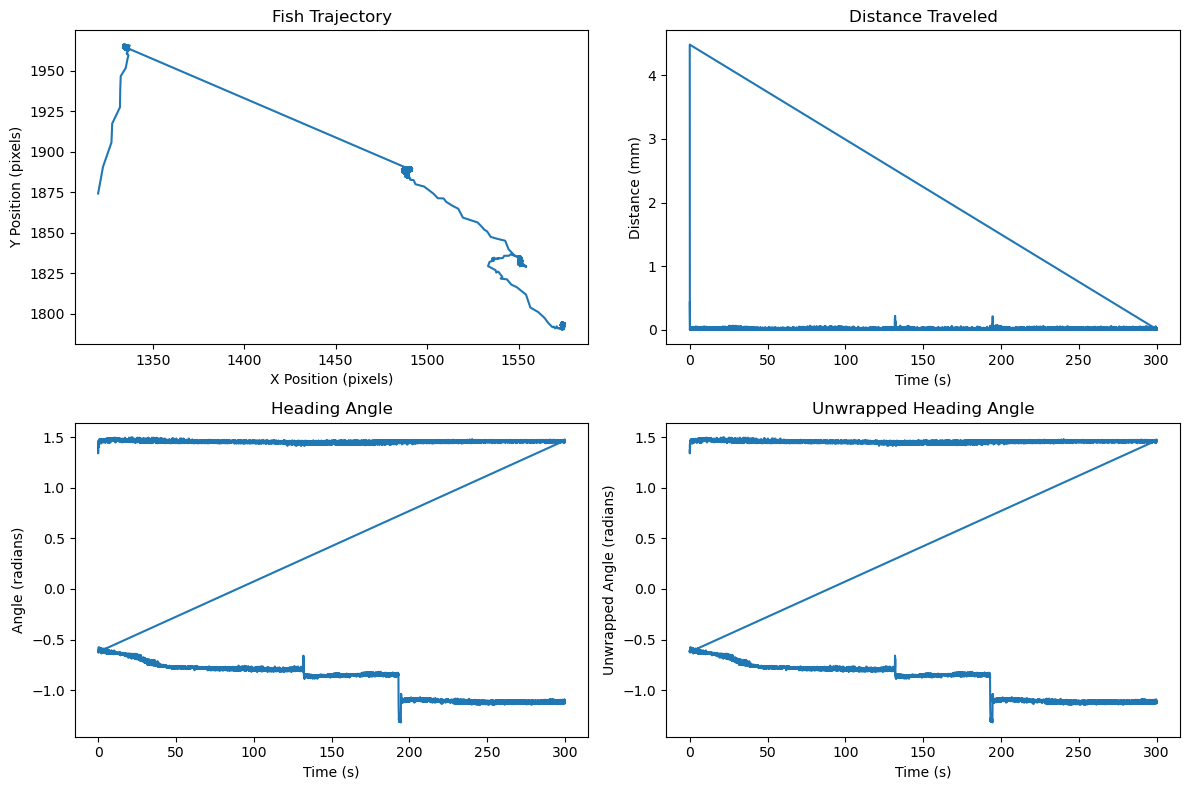

In [36]:
dark_df = pd.read_csv(r'.\dark_data.csv')
# Preprocessing
dark_df['relative_time'] = get_relative_time(dark_df)
dark_df['relative_index'] = get_relative_index(dark_df)
dark_df['distance'] = get_distance(dark_df)
dark_df['angle'], dark_df['unwrapped_angle'] = get_heading_angle(dark_df)

# Trajectory Visualization
plt.figure(figsize=(12, 8))

# Trajectory plot
plt.subplot(2, 2, 1)
plt.plot(dark_df['centroid_x'], dark_df['centroid_y'])
plt.title('Fish Trajectory')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')

# Distance over time
plt.subplot(2, 2, 2)
plt.plot(dark_df['relative_time'], dark_df['distance'])
plt.title('Distance Traveled')
plt.xlabel('Time (s)')
plt.ylabel('Distance (mm)')

# Heading angle over time
plt.subplot(2, 2, 3)
plt.plot(dark_df['relative_time'], dark_df['angle'])
plt.title('Heading Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')

# Unwrapped angle over time
plt.subplot(2, 2, 4)
plt.plot(dark_df['relative_time'], dark_df['unwrapped_angle'])
plt.title('Unwrapped Heading Angle')
plt.xlabel('Time (s)')
plt.ylabel('Unwrapped Angle (radians)')

plt.tight_layout()
plt.show()

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_8628\3029309498.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


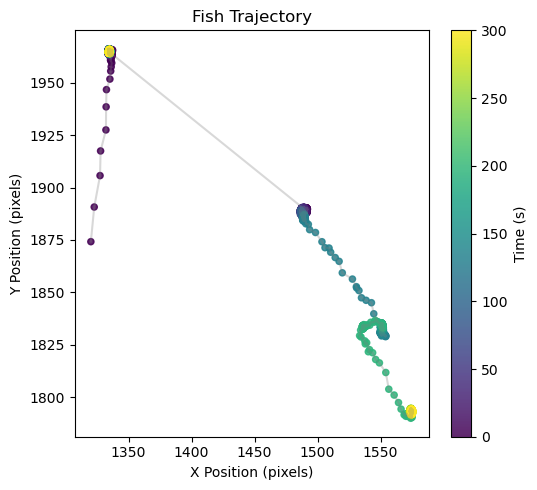

In [55]:
plt.figure(figsize=(15, 5))

# Trajectory plot with smoother time gradient
plt.subplot(1, 3, 1)
# Create a custom colormap that transitions more smoothly
custom_cmap = plt.cm.get_cmap('viridis')
plt.scatter(
    dark_df['centroid_x'], 
    dark_df['centroid_y'], 
    c=dark_df['relative_time'], 
    cmap=custom_cmap, 
    s=20,  # Smaller point size
    alpha=0.85  # Slight transparency
)
plt.colorbar(label='Time (s)')
plt.title('Fish Trajectory')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')

# Optional: Add a line plot underneath the scatter to show path
plt.plot(
    dark_df['centroid_x'], 
    dark_df['centroid_y'], 
    color='gray', 
    linewidth=1.5, 
    alpha=0.3
)

# Rest of the visualization remains the same
# ... (distance and velocity plots)

plt.tight_layout()
plt.show()

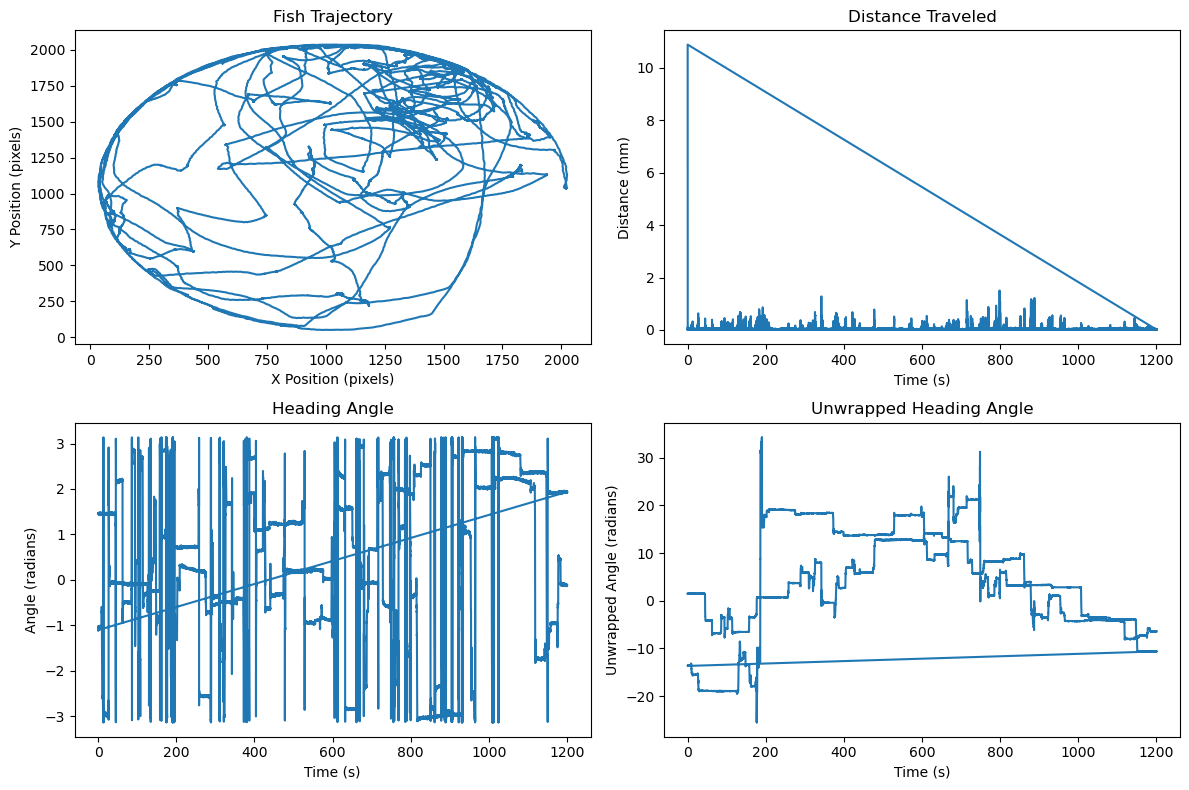

In [50]:
phototaxis_df = pd.read_csv(r'.\phototaxis_data.csv')
# Preprocessing
phototaxis_df['relative_time'] = get_relative_time(phototaxis_df)
phototaxis_df['relative_index'] = get_relative_index(phototaxis_df)
phototaxis_df['distance'] = get_distance(phototaxis_df)
phototaxis_df['angle'], phototaxis_df['unwrapped_angle'] = get_heading_angle(phototaxis_df)

# Trajectory Visualization
plt.figure(figsize=(12, 8))

# Trajectory plot
plt.subplot(2, 2, 1)
plt.plot(phototaxis_df['centroid_x'], phototaxis_df['centroid_y'])
plt.title('Fish Trajectory')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')

# Distance over time
plt.subplot(2, 2, 2)
plt.plot(phototaxis_df['relative_time'], phototaxis_df['distance'])
plt.title('Distance Traveled')
plt.xlabel('Time (s)')
plt.ylabel('Distance (mm)')

# Heading angle over time
plt.subplot(2, 2, 3)
plt.plot(phototaxis_df['relative_time'], phototaxis_df['angle'])
plt.title('Heading Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')

# Unwrapped angle over time
plt.subplot(2, 2, 4)
plt.plot(phototaxis_df['relative_time'], phototaxis_df['unwrapped_angle'])
plt.title('Unwrapped Heading Angle')
plt.xlabel('Time (s)')
plt.ylabel('Unwrapped Angle (radians)')

plt.tight_layout()
plt.show()

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_8628\990112022.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


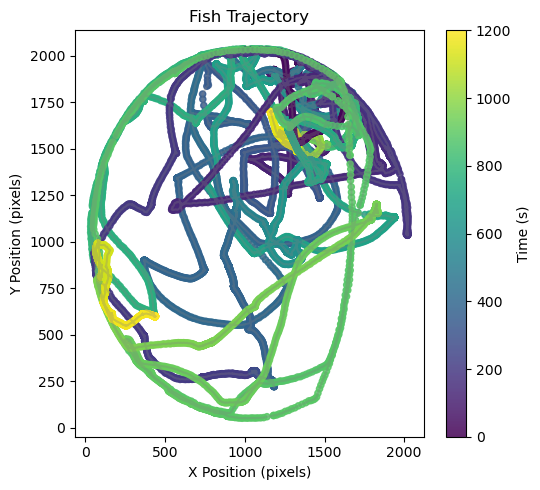

In [56]:
plt.figure(figsize=(15, 5))

# Trajectory plot with smoother time gradient
plt.subplot(1, 3, 1)
# Create a custom colormap that transitions more smoothly
custom_cmap = plt.cm.get_cmap('viridis')
plt.scatter(
    phototaxis_df['centroid_x'], 
    phototaxis_df['centroid_y'], 
    c=phototaxis_df['relative_time'], 
    cmap=custom_cmap, 
    s=20,  # Smaller point size
    alpha=0.85  # Slight transparency
)
plt.colorbar(label='Time (s)')
plt.title('Fish Trajectory')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')

# Optional: Add a line plot underneath the scatter to show path
plt.plot(
    phototaxis_df['centroid_x'], 
    phototaxis_df['centroid_y'], 
    color='gray', 
    linewidth=1.5, 
    alpha=0.3
)

# Rest of the visualization remains the same
# ... (distance and velocity plots)

plt.tight_layout()
plt.show()

In [ ]:




def analyse_phototaxis(data, fish_id, dpf):
    phototaxis = data[data['stim_id'] == StimType.PHOTOTAXIS]

    def get_data(polarity):
        pol = phototaxis[phototaxis['phototaxis_polarity'] == polarity]
        time = get_relative_time(pol)
        angle, angle_unwrapped = get_heading_angle(pol)
        res = pd.DataFrame({
            'time': time, 
            'angle': angle, 
            'angle_unwrapped': angle_unwrapped,
            'polarity': polarity,
            'fish_id': fish_id,
            'dpf': dpf
        })
        res = res.set_index(get_relative_index(pol))
        return res

    res = pd.concat((get_data(1),get_data(-1)))
    return res



def plot_heading_angle(data):
    angle, angle_unwrapped = get_heading_angle(data)
    distance = get_distance(data)

    plt.figure()
    ax1 = plt.subplot(311)
    ax1.plot(
        data['t_local'], 
        angle
    )
    ax2 = plt.subplot(312, sharex=ax1)
    ax2.plot(
        data['t_local'], 
        angle_unwrapped
    )
    ax2.set_ylabel('cum. angle')
    ax3 = plt.subplot(313, sharex=ax1)
    ax3.plot(
        data['t_local'], 
        distance
    )
    ax3.set_ylabel('distance')
    plt.show()

In [11]:
DATA_FOLDER = r".\Modelling_data\Cichlids"

DATAFILES = [
    "08_09dpf_Di_27_Aug_2024_14h50min47sec.csv", 
    "09_09dpf_Di_27_Aug_2024_16h03min14sec.csv"
]

phototaxis = pd.DataFrame()

for file in DATAFILES:
    print(file)
    fish_id, dpf, date = parse_filename(file)
    data = pd.read_csv(os.path.join(DATA_FOLDER,file))
    data_filtered = data.groupby('image_index').first()
    data_filtered = data_filtered[1:]
    data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
    #phototaxis = data_filtered[['t_display', 't_local', 'latency', 'centroid_x', 'centroid_y', 'pc1_x',
     #  'pc1_y', 'pc2_x', 'pc2_y',]] 
    phototaxis = pd.concat((
        phototaxis, 
        analyse_phototaxis(data_filtered, fish_id, dpf)
    ))

    ## save 
phototaxis.to_csv('phototaxis.csv')

## load
phototaxis = pd.read_csv('phototaxis.csv')
print(phototaxis.head)

08_09dpf_Di_27_Aug_2024_14h50min47sec.csv
09_09dpf_Di_27_Aug_2024_16h03min14sec.csv
<bound method NDFrame.head of         image_index        time     angle  angle_unwrapped  polarity  fish_id  \
0                 0    0.000000  0.025864         0.025864         1        8   
1                 1    0.016780  0.025864         0.025864         1        8   
2                 2    0.037573  0.034523         0.034523         1        8   
3                 3    0.050093  0.018354         0.018354         1        8   
4                 4    0.066864  0.011306         0.011306         1        8   
...             ...         ...       ...              ...       ...      ...   
144008        36000  600.003596 -1.213488        30.202439        -1        9   
144009        36001  600.020272 -1.244798        30.171129        -1        9   
144010        36002  600.036948 -1.222917        30.193010        -1        9   
144011        36003  600.053653 -1.178235        30.237691        -1        

In [5]:
print(phototaxis.columns)

Index(['image_index', 'time', 'angle', 'angle_unwrapped', 'polarity',
       'fish_id', 'dpf'],
      dtype='object')


In [8]:
print(phototaxis.columns)

Index(['image_index', 't_display', 't_local', 'latency', 'centroid_x',
       'centroid_y', 'pc1_x', 'pc1_y', 'pc2_x', 'pc2_y', 'time', 'angle',
       'angle_unwrapped', 'polarity', 'fish_id', 'dpf'],
      dtype='object')


In [10]:
phototaxis.shape

(305814, 16)

In [12]:
phototaxis.shape

(144013, 7)

In [14]:
phototaxis.isnull().any()

image_index        False
time               False
angle              False
angle_unwrapped    False
polarity           False
fish_id            False
dpf                False
dtype: bool

In [17]:
data_filtered.isnull().sum()

t_display                             0
t_local                               0
latency                               0
centroid_x                            0
centroid_y                            0
                                     ..
looming_center_mm_x                   0
looming_center_mm_y                   0
looming_period_sec                    0
looming_expansion_time_sec            0
looming_expansion_speed_mm_per_sec    0
Length: 107, dtype: int64

In [39]:
def plot_fish_trajectories(data):
    # Create a figure with subplots for each stimulus type
    stim_types = [StimType.DARK, StimType.BRIGHT, StimType.PHOTOTAXIS]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, stim_type in enumerate(stim_types):
        # Filter data for specific stimulus type
        stim_data = data[data['stim_id'] == stim_type]
        
        # Create scatter plot with color gradient based on time
        scatter = axes[i].scatter(
            stim_data['centroid_x'], 
            stim_data['centroid_y'],
            c=stim_data['t_local'],  # Color based on time
            cmap='viridis',       # Color gradient
            s=20                  # Point size
        )
        
        # Add colorbar
        plt.colorbar(scatter, ax=axes[i], label='Time')
        
        # Set labels and title
        axes[i].set_title(f'Trajectory for {stim_type.name}')
        axes[i].set_xlabel('Centroid X')
        axes[i].set_ylabel('Centroid Y')
        
        # Optional: add arrows to show direction
        for j in range(len(stim_data)-1):
            axes[i].annotate('', 
                xy=(stim_data['centroid_x'].iloc[j+1], stim_data['centroid_y'].iloc[j+1]),
                xytext=(stim_data['centroid_x'].iloc[j], stim_data['centroid_y'].iloc[j]),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.3)
            )
    
    plt.tight_layout()
    plt.show()

# Assuming 'data' is your preprocessed DataFrame
plot_fish_trajectories(data_filtered)

KeyboardInterrupt: 